In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
df = pd.read_csv('/content/Case3_Dataset.csv')
df.head()

,Unnamed: 0,text,label
0,16252,analysts equally say that the feat of keeping ...,American English
1,14684,a bitter struggle between supporters of zuma a...,American English
2,11731,microsoft has been in the cellphone software m...,American English
3,14742,the constitution allows the imposition of mart...,American English
4,14521,st louis rams how the rams fare on the threega...,American English


In [3]:
df.duplicated().sum()

0

In [4]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [5]:
df.shape

(50000, 3)

In [6]:
unique_language_ids = df['label'].unique()
print(unique_language_ids)

['American English' 'Argentine Spanish' 'Bosnian' 'Brazilian Portuguese'
 'British English' 'Castilian Spanish' 'Croatian' 'European Portuguese'
 'Peruvian Spanish' 'Serbian']


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40000, 40000, 10000, 10000)

In [10]:
print("Missing values in X_train:", X_train.isnull().sum())
print("Missing values in X_test:", X_test.isnull().sum())

Missing values in X_train: 1
Missing values in X_test: 0


In [11]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

## NAIVE BAYES

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline


model = make_pipeline(TfidfVectorizer(ngram_range=(1, 1), analyzer='word'), MultinomialNB())

model.fit(X_train, y_train)
pred_labels = model.predict(X_test)
from sklearn.metrics import classification_report
report = classification_report(y_test, pred_labels,digits=4)

print('Classification Report:')
print(report)

Classification Report:
                      precision    recall  f1-score   support

    American English     0.5493    0.5302    0.5396      1009
   Argentine Spanish     0.7159    0.8723    0.7864      1034
             Bosnian     0.7410    0.6041    0.6655       985
Brazilian Portuguese     0.8773    0.9008    0.8889      1008
     British English     0.5320    0.5568    0.5441       986
   Castilian Spanish     0.6701    0.8738    0.7585      1030
            Croatian     0.8155    0.8227    0.8191      1021
 European Portuguese     0.8951    0.8649    0.8798       977
    Peruvian Spanish     0.9211    0.4031    0.5608       955
             Serbian     0.7657    0.8935    0.8247       995

            accuracy                         0.7348     10000
           macro avg     0.7483    0.7322    0.7267     10000
        weighted avg     0.7472    0.7348    0.7279     10000



## LOGISTIC REGRESSION

In [13]:
from sklearn.linear_model import LogisticRegression
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 1), analyzer='word'), LogisticRegression())

# Fitting the model on the training data
model.fit(X_train, y_train)

pred_labels = model.predict(X_test)

report = classification_report(y_test, pred_labels,digits=4)

print('Classification Report:')
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                      precision    recall  f1-score   support

    American English     0.5416    0.5164    0.5287      1009
   Argentine Spanish     0.8385    0.7582    0.7963      1034
             Bosnian     0.6722    0.6183    0.6441       985
Brazilian Portuguese     0.8507    0.8760    0.8631      1008
     British English     0.5280    0.5548    0.5410       986
   Castilian Spanish     0.8118    0.7621    0.7862      1030
            Croatian     0.7500    0.7992    0.7738      1021
 European Portuguese     0.8731    0.8311    0.8516       977
    Peruvian Spanish     0.7459    0.8576    0.7979       955
             Serbian     0.7635    0.7980    0.7803       995

            accuracy                         0.7370     10000
           macro avg     0.7375    0.7372    0.7363     10000
        weighted avg     0.7381    0.7370    0.7365     10000



## BERT

In [14]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn.functional as F
import pandas as pd

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=12)

path = '/content/Case3_Dataset.csv'
def load_data(path):
    df = pd.read_csv(path)

    # Convert non-string values to strings
    df['text'] = df['text'].astype(str)

    X = df['text'].tolist()
    y = df['label'].tolist()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y

    X = df['text'].tolist()
    y = df['label'].tolist()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
X, y = load_data("/content/Case3_Dataset.csv")

tokenized_data = tokenizer(X, padding=True, truncation=True, max_length=64, return_tensors="pt")
input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]
labels = torch.tensor(y)

dataset = TensorDataset(input_ids, attention_mask, labels)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3

# Learning rate scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Gradient accumulation
accumulation_steps = 2

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    true_labels_train = []
    predicted_labels_train = []

    for i, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        # Accumulate gradients over accumulation_steps
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()

        # Append true and predicted labels for each batch
        true_labels_train.extend(labels.cpu().numpy())
        predicted_labels_train.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

    average_loss = total_loss / len(train_dataloader)
    accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {average_loss} | Training Accuracy: {accuracy_train:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    true_labels_val = []
    predicted_labels_val = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            # Append true and predicted labels for each batch in validation
            true_labels_val.extend(labels.cpu().numpy())
            predicted_labels_val.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)

    # Calculate precision, recall, and F1 score for validation
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_val, predicted_labels_val, average='weighted')
    print(f"Validation Loss: {average_val_loss} | Validation Accuracy: {accuracy_val:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

# Saving the fine-tuned model weights
model.save_pretrained("/content/DistilBERT_finetuned/")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Training Loss: 0.8920673288106918 | Training Accuracy: 0.5603
Validation Loss: 0.6294047208309174 | Validation Accuracy: 0.6838
Precision: 0.6994 | Recall: 0.6838 | F1 Score: 0.6541
Epoch 2/3
Training Loss: 0.5817733925461769 | Training Accuracy: 0.7170
Validation Loss: 0.5531836352169514 | Validation Accuracy: 0.7318
Precision: 0.7509 | Recall: 0.7318 | F1 Score: 0.7269
Epoch 3/3
Training Loss: 0.48886080385372044 | Training Accuracy: 0.7622
Validation Loss: 0.5112557542353868 | Validation Accuracy: 0.7492
Precision: 0.7531 | Recall: 0.7492 | F1 Score: 0.7387


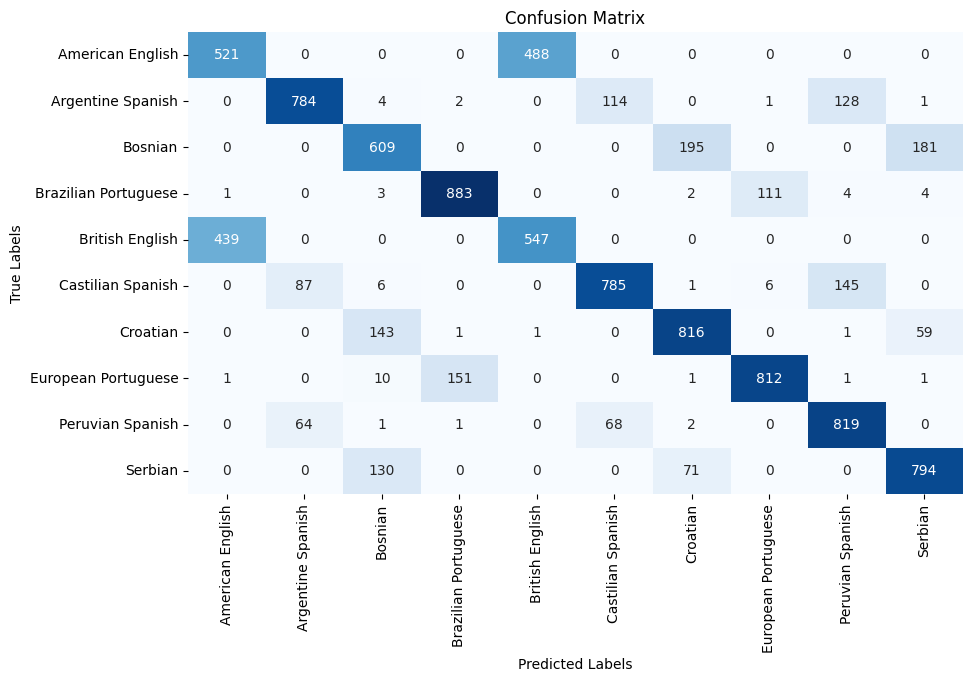

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = [
    'American English', 'Argentine Spanish', 'Bosnian', 'Brazilian Portuguese',
    'British English', 'Castilian Spanish', 'Croatian', 'European Portuguese',
    'Peruvian Spanish', 'Serbian']
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_labels)

# Plotting the confusion matrix using seaborn with class labels
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()